# Introduction to Mixture Models

-----


In this notebook, we introduce the concept of a mixture model, which is a parametric model that describes a data set. A parametric model can be written down as a formula, for example, $y = mx + b$ is a parametric model describing a line in two-dimensions. This type of model can be extremely useful as it is easy to interpret and can be used to make predictions on new, unseen data. For a mixture model, we generate a parametric representation of a data set that contains multiple models. This representation is constructed in an unsupervised manner and can be used to identify clusters within a data set.

While a mixture model can employ any parametric form, one of the simplest to use is a mixture of Gaussians, which is known as a [Gaussian Mixture Model (GMM)][wgmm]. In this case, we generate a model to cluster our data that is a combination of multiple Gaussians. This model is probabilistic in nature, and can be used to both identify to which cluster a new instance belongs, as well as to generate new data. These capabilities will be demonstrated within this notebook by analyzing both the Iris data set and the handwritten digit data set. 

-----
[wgmm]: https://en.wikipedia.org/wiki/Mixture_model

## Table of Contents

[Formalism](#Formalism)

[GMM: Iris Data](#k-Means:-Iris-Data)
- [GMM: Iris Clustering](#GMM:-Iris-Clustering)
- [GMM: Iris Number of Components](#GMM:-Iris-Number-of-Components)
- [GMM: Iris Covariance Type](#GMM:-Iris-Covariance-Type)

[GMM: Digit Data](#k-Means:-Digit-Data)
- [GMM: Digit Clustering](#GMM:-Digit-Clustering)
- [GMM: Digit Generative Model](#GMM:-Digit-Generative-Model)
- [GMM: Digit Number of Components](#GMM:-Digit-Number-of-Components)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

The Gaussian Mixture Model can be viewed as an extension of the k-means clustering process, in that we must specify a number of components ahead of time, but now the shape of the discovered clusters can vary with each dimension (or feature). Thus, while k-means found only spherical clusters in the Iris data, the GMM can find arbitrary elliptical-shaped clusters in this same data. In addition, the GMM produces a probabilistic classification for the membership of each instance in each cluster.

The GMM model is specified by four items:
1. The number of components (or clusters) used to build the mixture model
2. The fraction of the total data that _belong_ (probabilistically) to each component in the model
3. An array specifying the mean value for each component
4. The covariance matrix for each component

The process of constructing a Gaussian Mixture Model involves the expectation-maximization algorithm. In this case,  the expectation step (or E-step) of this algorithm finds weights for each instance in the data set that encode the probability that the instance belongs to each component (or cluster). The maximization step (or M-step) determines the location and shape of each component, based on all of the instances and weights computed during the E-step. This process continues iteratively until convergence is reached, which will produce a smooth Gaussian parametric representation of the data.

Like the k-means algorithm, A GMM is fairly fast to compute, and is easy to understand and visualize (covariances not-withstanding). However, since the EM algorithm is being used to find the parametric mixture, there is no guarantee of a globally optimal result. As a result, in practice we often run the algorithm multiple times with different initial conditions to generate multiple mixture models and we choose the best of these models as our final result.

We perform Gaussian mixture modeling with the scikit learn library by using the [`GaussianMixture`][skgmm] estimator in the `mixture` module. This estimator takes a number of hyperparameters, of which the following are generally the most important:

- `n_components`: the number of components (i.e., clusters) to use in the mixture model
- `covariance_type`: the type of covariance matrix to employ when constructing the mixture model (this controls the shape of the clusters)
- `tol`: the convergence threshold
- `n_init`: the number of initializations to perform, each initialization leads to a different mixture model
- `init_params`: indicates how the weights should be initialized, by default done by using the k-means algorithm
- `random_state`: this enables reproducibility when constructing a mixture model


-----
[skgmm]: http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

[[Back to TOC]](#Table-of-Contents)


## GMM: Iris Data


We will use the standard Iris data set to introduce the use of mixture models to identify clusters of instances. These data consist of 150 instances, equally split amongst three species, each with four primary features (or dimensions), which include Sepal Length, Sepal Width, Petal Length, and Petal Width. The next Code cell imports these data into the notebook, scales them to have zero mean and unit standard deviation, and generates a principal component transformation. The scaling is performed to ensure the mixture model treats each dimension in the same manner, and the PCA transformation will be used to create two-dimensional visualizations that will provide insight into the performance of the mixture model.

-----



In [2]:
from sklearn.preprocessing import StandardScaler

import sklearn.datasets as ds

# Load the digits data
iris = ds.load_iris()
    
# Extract the data and labels
x = StandardScaler().fit_transform(iris.data)
y = iris.target.reshape(x.shape[0], 1)

#
from sklearn.decomposition import PCA

# Principal Component Analysis
pca = PCA(n_components=2, random_state=23)

# Fit model to the data
xx = pca.fit_transform(x)

data = np.concatenate((xx, y), axis=1)

-----
[[Back to TOC]](#Table-of-Contents)

### GMM: Iris Clustering

We now apply the Gaussian Mixture Model to the Iris data. Formally, this technique will determine a parametric model that describes these data; however, we can use this parametric model to find clusters by determining to which group of data (i.e., species) each instance belongs. In the following Code cell, we create our mixture model by specifying several basic hyperparameters (that will be analyzed in more detail later in this notebook). We fit this model to the data and make predictions. Technically, we should perform a train-test split, but since the parametric model is determined in an unsupervised manner, we can gain some insight by comparing the true labels to the predicted labels. In the end, we compute and display the V measure score, which is a simple cluster scoring metric, and see that our result is close to the perfect score of one.

-----

In [3]:
# We will use kmeans form scikit-learn
from sklearn.mixture import GaussianMixture

# We build our model assuming three clusters
gmm = GaussianMixture(n_components=3, covariance_type='full')

# We fit our data to assign classes
gmm.fit(x)

# Obtain the predictions
y_pred = gmm.predict(x).reshape(y.shape[0], 1)

# Compute and display V measure score
from sklearn.metrics import v_measure_score
y_t = y.reshape(y.shape[0])
y_p = y_pred.reshape(y.shape[0])
print(f'GMM prediction score = {v_measure_score(y_t, y_p):4.2f}')

GMM prediction score = 0.90


-----

With the mixture model computed, we can extract the clusters by using the `means_` attribute on our mixture model. This array specifies each cluster's center as computed from the mixture model. We demonstrate this in the following Code cell where we extract the cluster center, via the `means_` attribute, transform them to the space defined by the first two principal components, and display the result.

-----

In [4]:
# Compute cluster centers
cc = gmm.means_
cc_pca = pca.transform(cc)

for idx, xy_c in enumerate(cc_pca):
    print(f'Cluster {idx} center located at ({xy_c[0]:4.2f}, {xy_c[1]:4.2f})')

Cluster 0 center located at (0.44, -0.54)
Cluster 1 center located at (-2.22, 0.29)
Cluster 2 center located at (1.67, 0.19)


-----

The mixture model is probabilistic in nature, and when assigned to new data the model returns the probability that the data belong to each mixture component (or cluster). In the following Code cell, we demonstrate this by extracting three instances from the original Iris data, which each happen to belong to one of the three different classes. We obtain the probabilistic predictions for each of these three instances by using the `predict_proba` function on our mixture model. This returns the probability that each instance belongs to each component. Finally, we display each instance and the probability that the instance belongs to each component. Notice how the probability of the dominant component, at least for these instances, is quite high, often extremely close to one. While the other probabilities are much smaller, often extremely small (e.g., `8.79e-44`).


-----

In [5]:
test_data = x[0: 101: 50]

mm = gmm.predict_proba(test_data)

for idx, td in enumerate(test_data):
    print(f'Data {idx}   : {td[0]:5.2f} ', end='')
    print(f'{td[1]:5.2f} {td[2]:5.2f} {td[3]:5.2f}')
    
    print(f'Mixtures : {mm[idx][0]:8.2e} ', end='')
    print(f'{mm[idx][1]:8.2e} {mm[idx][2]:8.2e}', end='\n\n')

Data 0   : -0.90  1.02 -1.34 -1.32
Mixtures : 1.07e-43 1.00e+00 5.88e-35

Data 1   :  1.40  0.33  0.54  0.26
Mixtures : 1.00e+00 3.13e-92 2.40e-04

Data 2   :  0.55  0.56  1.27  1.71
Mixtures : 1.39e-16 3.19e-203 1.00e+00



-----

The following Code cell plots the original data, marks each data point by the highest probability mixture component (or cluster), and marks each cluster’s center. From this visualization it is clear that with three components, the mixture model nicely recovers the three species, although there is some confusion in the overlap region between Iris Versicolor and Iris Virginica. Since this model was computed in an unsupervised manner, this is actually a remarkable result, and demonstrates the power of mixture models.

-----

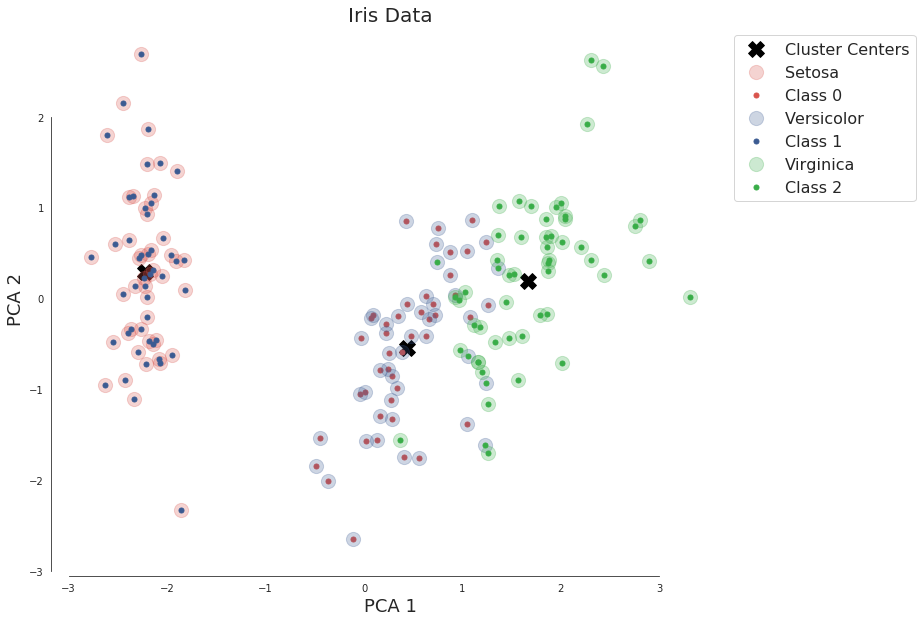

In [6]:
from helper_code import mlplots as mp
# Now we compare the cluster assignments to the real classes.

# Two sets of colors, can modify these to ensure colors match 
# between known and predicted clusters.
clr = [sns.xkcd_rgb['pale red'], 
       sns.xkcd_rgb['denim blue'], 
       sns.xkcd_rgb['medium green']]

pclr = [sns.xkcd_rgb['pale red'], 
        sns.xkcd_rgb['denim blue'],
        sns.xkcd_rgb['medium green']]

# Label data
lbls = ['Setosa', 'Versicolor', 'Virginica']
plbls = ['Class 0', 'Class 1', 'Class 2']
cols = ['PCA1', 'PCA2', 'Species']

# Data
dt = pd.DataFrame(data, columns = cols)

# Predicted Clusters
pc = pd.DataFrame(np.concatenate((xx, y_pred), axis=1), 
                  columns = cols)

# Now make the plot

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(cc_pca[:,0], cc_pca[:,1], 
           s=250, c='k', marker='X', label='Cluster Centers')

mp.plot_iris(dt, pc, clr, pclr, lbls, plbls, ax)

sns.despine(offset=5, trim=True)

-----

Since the mixture model is probabilistic in nature, we can also compute and display the probability surfaces for each cluster. In the following Code cell, we generate a uniformly spaced mesh across the space occupied by the Iris data, and apply the Gaussian Mixture Model to this mesh by using the `score_samples` function. This function returns the weighted log probabilities for each sample point, which allows us to generate a contour plot of the likelihood of the model at each mesh point. 

The plotting code is slightly more complex since the data are the logarithm of the probabilities (otherwise we would need to exponentiate the return values, but this is problematic as the data range would become extremely large). Thus, the contour plotting code has to use a `LogNorm` for the contour range and the contours are logarithmically spaced.

-----

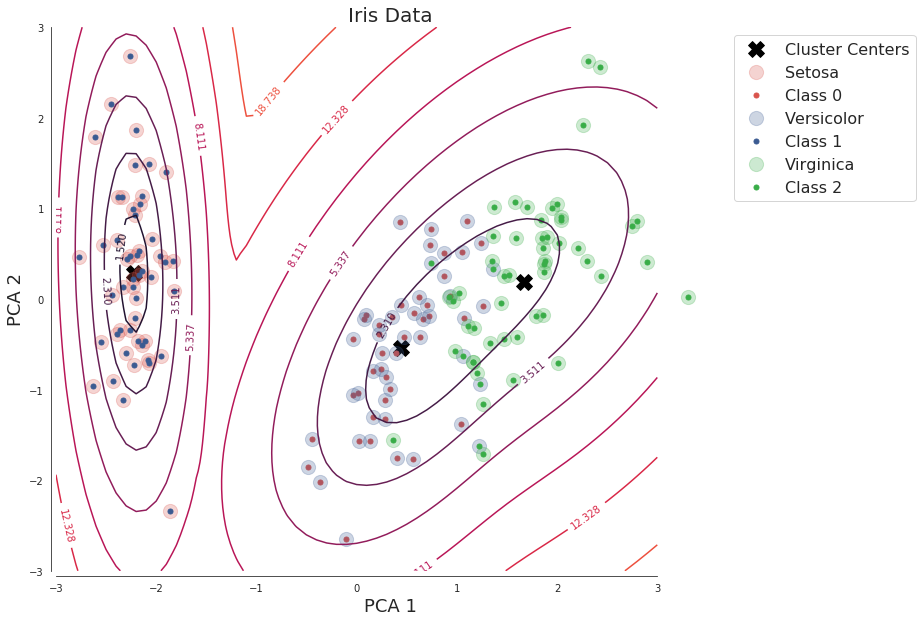

In [7]:
from matplotlib.colors import LogNorm

# Generate mesh grid of points
grid = np.arange(-3, 3.1, 0.1)
xg, yg = np.meshgrid(grid, grid)
grid_data = np.array([xg.ravel(), yg.ravel()]).T

# Compute sample scores for mesh.
gmm.fit(xx)
z = -1.0 * gmm.score_samples(grid_data).reshape(xg.shape)

# Now make the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Show data
ax.scatter(cc_pca[:,0], cc_pca[:,1], 
           s=250, c='k', marker='X', label='Cluster Centers')

# Plot the cluster centers and cluster identified data
mp.plot_iris(dt, pc, clr, pclr, lbls, plbls, ax)

# Overplot contours & label them
ct = ax.contour(xg, yg, z, norm=LogNorm(vmin=1.0, vmax=100.),
           levels=np.logspace(0, 2, 12))
ax.clabel(ct, inline=True, fontsize=10)

# Clean the plot
sns.despine(offset=5, trim=True, ax=ax)

-----
[[Back to TOC]](#Table-of-Contents)


### GMM: Iris Number of Components

Since the Gaussian Mixture Model produces probabilistic labels for each point belonging to each mixture (or cluster), we can employ information theory to quantify the quality of each mixture. The scikit learn library provides two such techniques: the [Akaike information criterion][waic] and the [Bayesian information criterion ][wbic]. Both of these approaches compute a likelihood of the quality of fit of a model to the data, where lower values are better. They also include penalty terms to penalize model complexity (in a similar manner to regularization).

While both techniques can be used for model selection, the AIC penalizes model complexity less than BIC. Yet, some theoretical arguments exist for choosing AIC over BIC when selecting models. In the end, it is often convenient to compute both and use both when choosing the best model (or in our case, the best number of Gaussians to use when fitting the digit data).

The following Code cell computes Gaussian Mixture Model fits to the Iris data for varying numbers of components. Specifically, we compute a GMM for these data for one through ten components. We accumulate the AIC and BIC values for each model fit by calling the `aic` and `bic` functions, as appropriate, on the computed model. In this initial example, we do not vary the other hyperparameters, such as `covariance_type`, which also might have a strong impact on model performance.

Give the model AIC and BIC scores, we can display the relevant score versus the number of components to determine the best number of components to use for a given data set and mixture model. In the second Code cell, we plot the number of components versus the AIC and BIC scores. The BIC score, which penalizes model complexity more strongly, drops quickly with a small number of components, but then rises as the number of components increases. The AIC, on the other hand continues to decline with an increasing number of components, but does so more slowly after three components. From both scores, we see that three components provides a good score, although both two and four provide similar scores.

-----

[waic]: https://en.wikipedia.org/wiki/Akaike_information_criterion
[wbic]: https://en.wikipedia.org/wiki/Bayesian_information_criterion

In [8]:
n_components = np.arange(1, 11)
aics = np.zeros_like(n_components)
bics = np.zeros_like(n_components)

for idx, nc in enumerate(n_components):
    # We build our model for nc components
    model = GaussianMixture(n_components=nc, covariance_type='full', 
                            n_init=10, random_state=23)
    model.fit(x)
    aics[idx] = model.aic(x)
    bics[idx] = model.bic(x)    

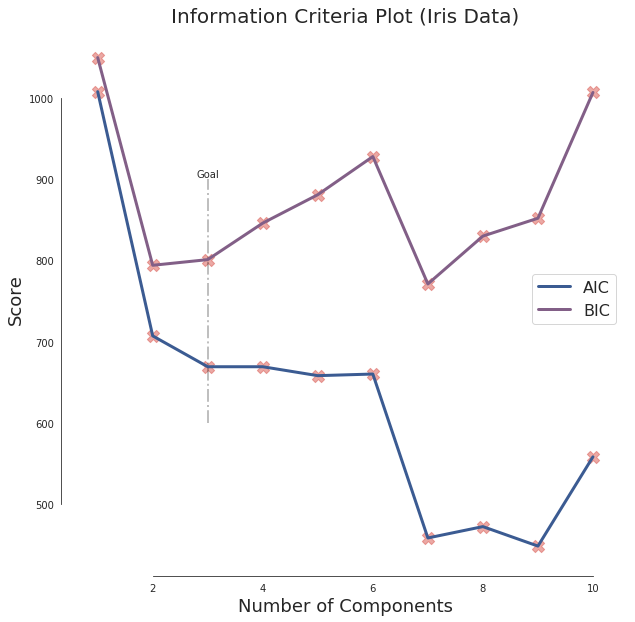

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

# Show AIC points an curve
ax.scatter(n_components, aics, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_components, aics, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'], label='AIC')

# Show BIC points an curve
ax.scatter(n_components, bics, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_components, bics, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['dusty purple'], label='BIC')

# Add information
ax.vlines(3.0, 600, 900, linestyles='-.', lw=2, alpha=0.25)
ax.text(3.0, 900, 'Goal', ha='center', va='bottom')
ax.legend(loc=7)

# Decorate Plot
ax.set(title='Information Criteria Plot (Iris Data)', 
       xlabel='Number of Components', 
       ylabel='Score')
sns.despine(offset=5, trim=True)

-----
[[Back to TOC]](#Table-of-Contents)


### GMM: Iris Covariance Type

The second major hyperparameter for the Gaussian Mixture Model is the covariance type used to compute each mixture's covariance matrix. The covariance matrix for an individual mixture specifies the shape of the mixture in the full dimensional space spanned by the data. With the scikit learn `GaussianMixture`, this hyperparameter can take one of four values:

- `spherical`: each mixture component has its own variance component. Thus the clusters are circular (in two-dimensions).
- `diag`: each mixture component has its own diagonal covariance matrix (i.e., only variances are used). Thus, the clusters are elliptical, but all share the same orientation and are aligned with the dimensions.
- `tied`: each mixture component shares a global covariance matrix. Thus, the clusters can be elliptical with an arbitrary orientation, but they are all equivalently shaped.
- `full`: each mixture component has its own covariance matrix. Thus, each cluster can have its own elliptical shape and orientation.

These four covariance types are demonstrated in the following Code cell, where the Iris data are plotted in two dimensions along with each mixture's model for the four different covariance types. As expected, we see circular clusters for `spherical`, dimensional-aligned ellipses for `diag`, equivalent ellipses for `tied`, and general ellipses for `full`. Thus, `full` provides the most generality, but will also be more computationally challenging given the greater model flexibility.

-----

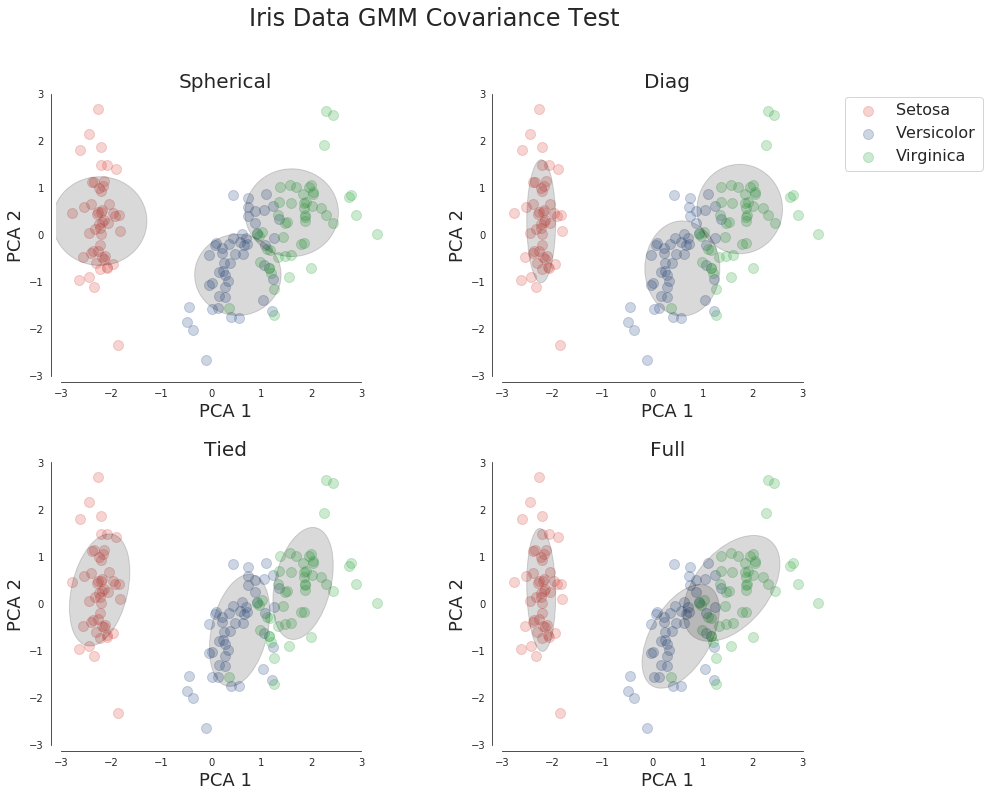

In [10]:
fig, axs = plt.subplots(figsize=(14, 12), nrows=2, ncols=2)
plt.suptitle('Iris Data GMM Covariance Test', fontsize=24)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Covariance Types
c_type = ['spherical', 'diag', 'tied', 'full']

# Now make the plot (Reuse code from helper functions)
for idx, ct in enumerate(c_type):
    gmm = GaussianMixture(n_components=3, covariance_type=ct).fit(xx)
    ax = axs.ravel()[idx]
    
    for i in range(3):
        tmp_df = dt[dt['Species'] == i]
        ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], 
               color=clr[i], label=lbls[i], alpha=0.25, s=100)
    
    mp.make_ellipses(gmm, ax, clr)
    
    ax.set(title=ct.capitalize(), xlabel='PCA 1', ylabel='PCA 2')

    sns.despine(offset=5, ax=ax, trim=True)
    
    if idx == 3:
        ax.legend(bbox_to_anchor=(1.0, 2.0), loc=3)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we constructed a Gaussian Mixture Model to represent the Iris data. Now that you have run those Code cells, go back and make the following changes. Be sure to think carefully about the results, and how the resulting model is different than the initial mixture model constructed in this notebook for these data.

1. Change the `covariance_type` hyperparameter and determine the best value for this hyperparameter by using the AIC and BIC scores.
3. Change the `init_params` to use random weight initialization and compare the resulting GMM to the default GMM constructed by using k-means initialization.


-----
[[Back to TOC]](#Table-of-Contents)


## GMM: Digit Data

We now switch our analysis to the handwritten digit data. These data are beneficial for two reasons. First, they are a representative data set in higher dimensions (i.e., sixty-four dimensions and ten classes). Second, it is easy to visualize the impact of a particular algorithm since the data are simply numbers. The following Code cell loads these data into the notebook and displays one representative image for each of the ten classes.

-----

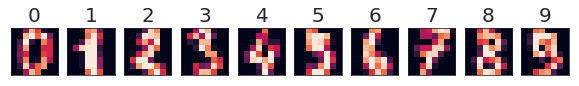

In [11]:
import sklearn.datasets as ds

# Load the digits data
digits = ds.load_digits()
    
# Now lets get the data and labels
x = digits.data
y = digits.target
images = digits.images

from helper_code import mlplots as mp
mp.plot_images(images[:10], np.arange(10))

-----
[[Back to TOC]](#Table-of-Contents)


### GMM: Digit Clustering

We now compute a Gaussian Mixture Model for the handwritten digit data. First, we create our model by specifying the hyperparameters `n_components` as ten, the `covariance_type` as full, which enables considerable flexibility for the computed covariance matrix, `n_init` as ten for multiple iterations to ensure we avoid local minima. After fitting this model to the unscaled digit data, we generate the mean image for each mixture component by converting the mixture mean components (via the `means_` model attribute) into images.

Looking over these images, we see that most of the mixture components are clearly visible. For example, mixture one is nine, three is seven, four is four, and seven is zero. On the other hand, mixtures zero and eight both look like six, and mixtures two, five, and nine are somewhat ambiguous. Of course, the mixture model is probabilistic and other machine learning techniques, such as manifold learning, have demonstrated that there is overlap between digit classes. Thus, we should not expect clean divisions between all mixtures with these data.

-----

In [12]:
# We build our model assuming ten clusters
gmm = GaussianMixture(n_components=10, covariance_type='full', 
                        n_init=10, random_state=23)


# We fit and transform our data to assign classes
model = gmm.fit(x)

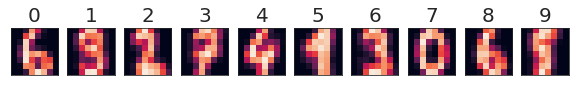

In [13]:
cntrs = np.zeros((10, 8, 8))

for idx in range(10):   
    cntrs[idx] = model.means_[idx, :].reshape(8, 8)
    
mp.plot_images(cntrs, np.arange(10))

-----
[[Back to TOC]](#Table-of-Contents)

### GMM: Digit Generative Model

The end state of computing a mixture model is a parametric representation of a given data set. This model can be used to perform clustering, as discussed in this notebook, by assigning new data to the highest probability cluster for each new datum. On the other hand, when given a model representation of a data set, we also can use the model to generate new data. Thus, we can treat a GMM as a generative model, in a similar manner as kernel density estimation, in order to supplement an existing data set or to visually understand the benefits and limitations of the computed model.

In the following two Code cells, we first generate new data, and next, display one representative image from each model cluster. The first Code cell calls the `sample` function on our GMM model. We specify `100` as a parameter to this function so that 100 new images are sampled from this generative model. In this case, we are very likely to get at least one representative image in each class. The data that is returned includes the sampled images (each as a sixty-four element array) and the cluster labels. We use the label array to find the first sampled instance from each cluster (with the np.unique function), this returns both the label and the index for each label in the full 100 element array.

The second Code cell uses these index values to extract out the corresponding image from the generated data. We reshape the sixty-four element array into an eight by eight, two-dimensional pixel array, and assign it to the new ten element image array. Finally, we plot the newly generated images. Note, the generative model is probabilistic, so simply looking at one example from each cluster is not representative of the full model, but even so, these images are insightful. 

First, there is no direct link between the label and the corresponding digit in the image, which is expected since the mixture model was constructed in an unsupervised manner. Second, some of the images are clearly distinct, such as for labels zero, three, four, seven, and nine, while others are more ambiguous, such as  labels one, two, five, six, and eight. To understand this model's generative performance, however, we would need to generate and analyze significantly more examples from each cluster, otherwise we are likely biased by small number statistics.

-----

In [14]:
# Sample 100 digits from mixture model
dd = model.sample(100)

# Extract unique labels, and their indices in digit array
lbls, idcs = np.unique(dd[1], return_index=True)

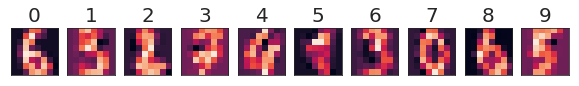

In [15]:
# Create empty array to hold image pixels
imgs = np.zeros((10, 8, 8))

# Fill pixel array with corresponding image
for idx, idc in enumerate(idcs):
    imgs[idx] = dd[0][idc].reshape(8, 8)

# Display generated images
mp.plot_images(imgs, np.arange(10))

-----
[[Back to TOC]](#Table-of-Contents)

### GMM: Digit Number of Components

In order to determine the optimal number of components for the best mixture model for the digit data, we can compute the AIC and BIC scores for different hyperparameter combinations. The following Code cell compute Gaussian Mixture Model fits to our digit data by varying only the numbers of components. Specifically, we compute a GMM for these data for six to fifteen components. We accumulate the AIC and BIC scores for each model fit by calling the `aic` and `bic` functions, as appropriate, on the computed model. In this initial example, we do not vary the other hyperparameters, such as `covariance_type`, which also might have a strong impact on model performance.

-----

In [16]:
#  We will explore how well different number of component
# Gaussians fit the digit data, from 6 to 15.
n_components = np.arange(6, 16)

# We compute AIC and BIC
aics = np.zeros_like(n_components)
bics = np.zeros_like(n_components)

# Build GMM for each number of components
# and accumulate AIC and BIC values
for idx, nc in enumerate(n_components):
    # We build our model for nc components
    model = GaussianMixture(n_components=nc, covariance_type='full', 
                            n_init=10, random_state=23)
    model.fit(x)
    aics[idx] = model.aic(x)
    bics[idx] = model.bic(x)    

-----

In the following Code cell, we plot the number of components versus the AIC and BIC scores. The BIC score, which penalizes model complexity more strongly, rises as the number of components increases, with a sharp drop at ten components. The AIC, on the other hand drops with increasing number of components, but has a sharp drop at ten components. In both cases, we see that ten components induces a strong change in the score, suggesting that `n_components=10` is the optimal hyperparameter value.

-----

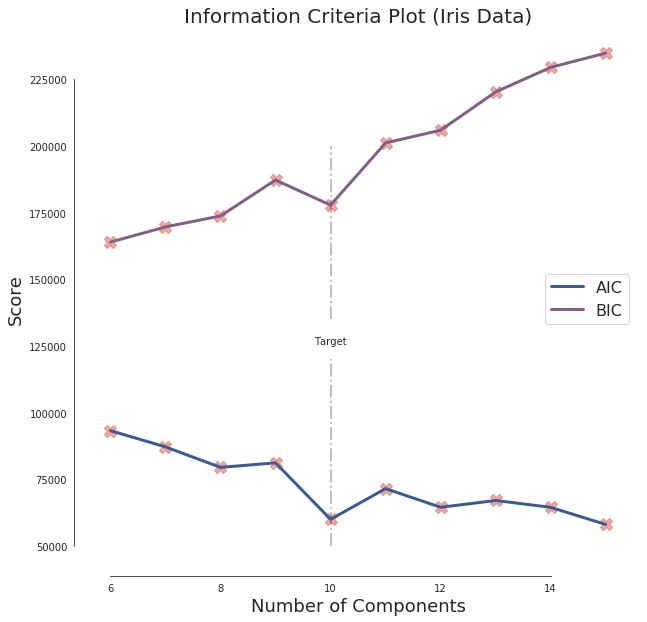

In [17]:
# Plot AIC and BIC values
fig, ax = plt.subplots(figsize=(10, 10))

# Show AIC points an curve
ax.scatter(n_components, aics, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_components, aics, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'], label='AIC')

# Show BIC points an curve
ax.scatter(n_components, bics, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_components, bics, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['dusty purple'], label='BIC')

# Add information
ax.vlines(10.0, 50000, 120000, linestyles='-.', lw=2, alpha=0.25)
ax.vlines(10.0, 135000, 200000, linestyles='-.', lw=2, alpha=0.25)
ax.text(10.0, 125000, 'Target', ha='center', va='bottom')
ax.legend(loc=7)

# Decorate Plot
ax.set(title='Information Criteria Plot (Iris Data)', 
       xlabel='Number of Components', 
       ylabel='Score')
sns.despine(offset=5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we constructed a Gaussian Mixture Model to represent the digit data. Now that you have run those Code cells, go back and make the following changes. Be sure to think carefully about the results, and how the resulting model is different than the initial mixture model constructed in this notebook for these data.

1. Change the `covariance_type` hyperparameter and determine the best value for this hyperparameter by using the AIC and BIC scores.
3. Perform PCA dimension reduction on the digit data to twenty and ten components. For each of these new representations, construct a GMM and compare the results obtained to the GMM constructed on the full data set.

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Visual wiki article on [Gaussian Mixture Models][1]
1. Blog article introducing [Gaussian Mixture Models][2]
2. The scikit learn [Gaussian Mixture Model][3] discussion
4. A Python based discussion on the [EM algorithm][4], which underlies GMM

-----

[1]: https://wikivisually.com/wiki/Gaussian_mixture_model
[2]: http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/
[3]: http://scikit-learn.org/stable/modules/mixture.html
[4]: https://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 